### Session 1: Model trainning
Place the program time_double_string.py and test_correlation.py in the same directory of this file.<br>
Download the geomagnetic indices data (symh_sme_20xx.csv), the satellite coordinates data (coord_20xx?.csv), and the RBSPICE spin-averaged flux data (rbspice?_p_20xx.csv) and place them in the directory of dir0 (self-defined). Then run the code below.

In [13]:
import numpy as np
import datetime as dt
import pandas as pd
import tensorflow as tf
from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from time_double_string import time_double,time_string
from test_correlation import lws_rbspice_loss_function_history, lws_rbspice_correlation
np.random.seed(46)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # This is to disable GPU

## Load geomagnetic indices from 2012-10-01 to 2018-12-31 (we need the history 
#  of geomagnetic indices to predict particle fluxes)
#  Load satellite orbit data and rbspice spinaveraged proton flux from 2013-01-01 
#  to 2018-12-31
dir0="/rcpann/"
probes=['a','b']#,'b']
n_probes=len(probes)

df_symh    = pd.read_csv(dir0+'geomag_2012_2018.csv')
df_coord_a = pd.read_csv(dir0+'coord_2013_2018_a.csv')
df_coord_b = pd.read_csv(dir0+'coord_2013_2018_b.csv')
df_coord   = pd.concat([df_coord_a,df_coord_b],ignore_index=True)
df_flux_a  = pd.read_csv(dir0+'rbspice_p_2013_2018_a.csv')
df_flux_b  = pd.read_csv(dir0+'rbspice_p_2013_2018_b.csv')
df_flux    = pd.concat([df_flux_a,df_flux_b],ignore_index=True)
del df_coord_a, df_coord_b, df_flux_a, df_flux_b


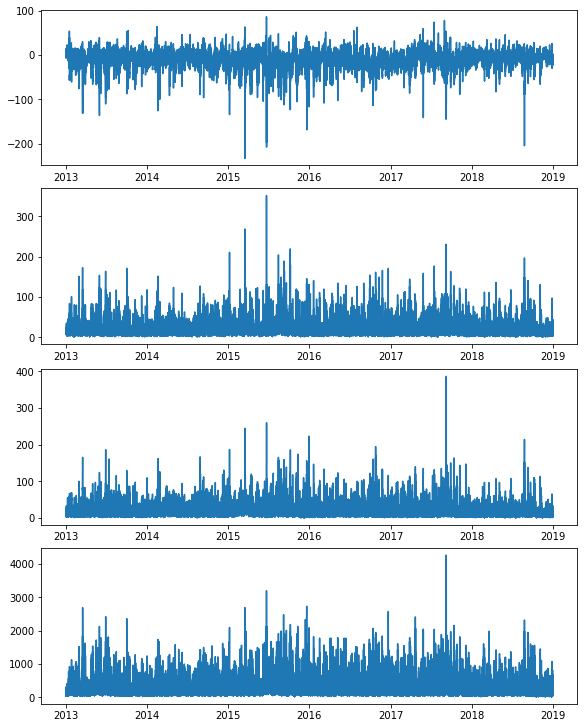

In [14]:
# Extra Code - clean solar wind data
# In case that we need to use solar wind data as input.
# Since there are some data gaps in solar wind measurements between 
# 2017-09-09 and 2017-09-12, we interpolate these data gaps.
ind_symh_1= np.where(df_symh['Datetime']=='2017-09-09 00:02:30')[0][0]
ind_symh_2= np.where(df_symh['Datetime']=='2017-09-12 00:02:30')[0][0]
for i in range(ind_symh_1, ind_symh_2):
    if (~np.isfinite (df_symh['Pressure'][i])):
        df_symh.loc[i,'Pressure'] = df_symh.loc[i-1,'Pressure']
        df_symh.loc[i,'Density'] = df_symh.loc[i-1,'Density']
        df_symh.loc[i,'Vx'] = df_symh.loc[i-1,'Vx']
        df_symh.loc[i,'Bz'] = df_symh.loc[i-1,'Bz']
        #df_symh['Pressure'][i] = df_symh['Pressure'][i-1]
        #df_symh['Bz'][i] = df_symh['Bz'][i-1]
        #df_symh['Vx'][i] = df_symh['Vx'][i-1]
        #df_symh['Density'][i] = df_symh['Density'][i-1]

# Extra code - visualize SymH index
tstr_plot_begin='2013-01-01 00:00:00'
tstr_plot_end='2019-01-01 00:00:00'
indt1_symh=np.where(df_symh['Datetime'] >= tstr_plot_begin)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] <= tstr_plot_end)
indt2_symh=indt2_symh[0][-1]+1

tarr_dt=df_symh['Datetime'].astype('datetime64')[indt1_symh:indt2_symh].reset_index(drop=True)
fig1, ax1 = plt.subplots(4,1, constrained_layout=True)
fig1.set_size_inches(8, 10)
ax1[0].plot(tarr_dt,df_symh["SymH"][indt1_symh:indt2_symh])
ax1[1].plot(tarr_dt,df_symh["AsyH"][indt1_symh:indt2_symh])
ax1[2].plot(tarr_dt,df_symh["AsyD"][indt1_symh:indt2_symh])
ax1[3].plot(tarr_dt,df_symh["SME"][indt1_symh:indt2_symh])


In [15]:
df_coord

,Datetime,Xsm,Ysm,Zsm,L,MLT,LAT
0,2013-01-01 00:02:30,-4.29839,-3.32747,-1.34413,5.94286,2.51628,-0.24241
1,2013-01-01 00:07:30,-4.26839,-3.41716,-1.34378,5.97146,2.57865,-0.24099
2,2013-01-01 00:12:30,-4.23491,-3.50448,-1.34228,5.99675,2.64057,-0.23950
3,2013-01-01 00:17:30,-4.19800,-3.58940,-1.33966,6.01876,2.70209,-0.23795
4,2013-01-01 00:22:30,-4.15771,-3.67188,-1.33597,6.03753,2.76329,-0.23634
...,...,...,...,...,...,...,...
1262011,2018-12-31 23:37:30,-2.75317,1.99118,0.91610,3.77549,21.60830,0.26336
1262012,2018-12-31 23:42:30,-2.72980,1.80313,0.85925,3.61641,21.77030,0.25684
1262013,2018-12-31 23:47:30,-2.69712,1.60856,0.79916,3.45085,21.94590,0.24919
1262014,2018-12-31 23:52:30,-2.65390,1.40737,0.73563,3.27872,22.13750,0.24016


In [16]:
#Check Nan and Inf
datetime_arr=df_coord["Datetime"]
coord0 = df_coord.iloc[:,1:5]
symh_ae=df_symh.iloc[:,[11,12,13,14]].to_numpy()
flux_data=df_flux.iloc[:,1:]
ind_bad_flux=np.where(~np.isfinite(flux_data))

#Coord0: Xsm,Ysm,Zsm,L, MLT，LAT
#Coord1: L, cos(theta),sin(theta),Lat; all are scaled linearly to [-1,1]
LL0 =np.float32(df_coord.to_numpy()[:,4])
MLT0=np.float32(df_coord.to_numpy()[:,5])
LAT0=np.float32(df_coord.to_numpy()[:,6])
cost0=np.cos(MLT0*np.pi/12.0)
sint0=np.sin(MLT0*np.pi/12.0)
coord1=np.array([(LL0-2.5)/(6.57-2.5)*2.0-1.0,cost0,sint0,LAT0/0.35]) #L_max = 6.57, L_min = 2.5, Lat_max = 0.35 rad
coord1=coord1.transpose()

# Scale geomagnetic indices
Xlow =np.array([-100.,    0.,    0.,     0.])
Xhigh=np.array([  20.,  100.,  100.,  1500.]) 

for i in range(len(Xlow)):
    symh_ae[:,i] = (symh_ae[:,i] -Xlow[i])/(Xhigh[i]-Xlow[i])*2.0-1.0

## Create tsec_arr
N_symh,M_symh=symh_ae.shape
ind1_symh=np.where(df_symh["Datetime"] == df_coord["Datetime"][0])
ind1_symh=ind1_symh[0][0]
#print(df_symh.iloc[ind1_symh:N_symh,2])
xx=df_symh.iloc[ind1_symh:N_symh]
N_sample_per_probe=N_symh-ind1_symh
N_sample_total=(N_symh-ind1_symh)*len(probes)
df_symh
tsec_0=time_double(datetime_arr[0])
tsec_1=time_double(datetime_arr[N_sample_per_probe-1])
delta_t =time_double(datetime_arr[1])-time_double(datetime_arr[0])
tsec_arr=np.arange(N_sample_per_probe)*delta_t+tsec_0

# Mark data that should not be used
# Use Probe A data after 2016-11-01
# Use Probe B data before 2016-11-01
ind_a_bad = np.where(tsec_arr < time_double('2016-11-01'))[0]
ind_b_bad = np.where((tsec_arr > time_double('2016-11-01')) & (tsec_arr < time_double('2018-01-01')))[0]+len(tsec_arr)
if n_probes == 2:
    ind_bad = np.concatenate((ind_a_bad,ind_b_bad),axis=0)

In [17]:
## This section generate the feature matrix and data matrix X_y_all, which contains the solar wind and 
#  geomagnectic indics as inputs

# Time reslution is set to be two hours
Ind_t_symh=np.arange(-240*12,1,24)

N_feature_history=Ind_t_symh.size
n_col_coord=coord1.shape[1]
n_col_flux=flux_data.shape[1]

N_ftr=N_feature_history*M_symh
X_y_all =np.zeros([N_sample_total,(N_ftr+n_col_coord+n_col_flux)],dtype='float32')

X_y_all[0:N_sample_total,N_ftr:(N_ftr+n_col_coord)]=coord1
X_y_all[0:N_sample_total,-n_col_flux:]=flux_data

Mat_symh_ind=np.zeros([N_sample_total,N_feature_history])
for k in range(N_feature_history):
    X_y_all[0:N_sample_per_probe,(k*M_symh):(k+1)*M_symh]=symh_ae[(ind1_symh+Ind_t_symh[k]):(N_symh+Ind_t_symh[k]),:]
    if (len(probes)==2):
        X_y_all[N_sample_per_probe:N_sample_total,(k*M_symh):(k+1)*M_symh]=symh_ae[(ind1_symh+Ind_t_symh[k]):(N_symh+Ind_t_symh[k]),:]

# X_y_all columns are as follows:
# 0       1       2       3     ... 7      8       9       10      11    ...  15     16     ...  1020, 1021, 1022, 1023, 1024,     1025,     1026      1027
# SymH_1  AsyH_1  AsyD_1  SME_1 ... Bz_1;  SymH_2  AsyH_2  AsyD_2  SME_2 ...  Bz_2;  Symh_3 ...  X   , Y,    Z,    L,    rept[:,0] rept[:,1] rept[:,2] rept[:,3]
# SymH-240 AsyH-240 ...                 ;  SymH-238 AsyH-238

In [18]:
#Mark all bad data
ind_bad_Xy=np.where(~np.isfinite(X_y_all))
ind_bad_Xy_sorted=np.zeros(ind_bad_Xy[0].size)
k=0
ind_bad_Xy_sorted[0]=ind_bad_Xy[0][0]
for n in np.arange(1,ind_bad_Xy[0].size,1):
    if ind_bad_Xy[0][n] > ind_bad_Xy[0][n-1]:
        k+=1
        ind_bad_Xy_sorted[k]=ind_bad_Xy[0][n]
ind_bad_Xy_sorted=ind_bad_Xy_sorted[0:(k+1)].astype(int)


# X_y_cat: short for X_y_category
# X_y_cat[:,0] 1: data is bad and should not be in ML set; 0: good
# X_y_cat[:,1] data categories 0: train; 1:valid; 2:test
# X_y_cat[:,2] 1: L<2.5; 0: L>=2.5
X_y_cat=np.zeros([N_sample_total,3],dtype=int)
X_y_cat[ind_bad_Xy_sorted,0]=1 #Bad samples are marked as 1
X_y_cat[ind_bad,0]=1

# Extra code. To keep only 1 data sample per 0.1 L shell, set dL01=True
dL01=False
if (dL01):
    isMask=np.zeros(df_coord.shape[0])
    Lpre=100
    for i in range(df_coord.shape[0]):
        L10=np.floor(df_coord["L"][i]*10)
        if L10!=Lpre:
            isMask[i]=1
            Lpre=L10
        else:
            X_y_cat[i,0]=1 # mark bad data for rest of data samples in the same 0.1 L-shell region
    df_coord["isMask"]=isMask

In [19]:
# Mark Train, valid and test samples
# 0: train; 1:valid; 2:test


#Time range for test data set
tstr_test_begin='2017-01-01'
tstr_test_end='2018-01-01'
tsec_test_begin=time_double(tstr_test_begin)
tsec_test_end=time_double(tstr_test_end)


episode_time= 86400.0*2 
N_episode = np.ceil((tsec_1-tsec_0)/episode_time).astype(int)
N_episode_test_begin = np.ceil((tsec_test_begin-tsec_0)/episode_time).astype(int)
N_episode_test_end   = np.ceil((tsec_test_end  -tsec_0)/episode_time).astype(int)
episodes = np.arange(N_episode)
episodes = np.delete(episodes,np.arange(N_episode_test_begin,N_episode_test_end))
#If the test set is randomly split
#episode_train_full,episode_test=train_test_split(episodes, test_size=0.01, train_size=1.0, random_state=42)
#episode_train,episode_valid=train_test_split(episode_train_full, test_size=0.2, train_size=0.8, random_state=42)
#If the test set is not specified here but later in a time range
episode_test=[]
episode_train,episode_valid=train_test_split(episodes, test_size=0.2, train_size=0.8, random_state=42)

#print(episode_train.shape)
#print(episode_valid.shape)
#print(episode_test.shape)
#print(episode_train_full.shape)
Sample_per_episode=episode_time/delta_t #2106

# validation set
for k in range(len(episode_valid)):
    ind0=episode_valid[k]*Sample_per_episode
    ind1=(episode_valid[k]+1)*Sample_per_episode
    ind0=ind0.astype(int)
    ind1=ind1.astype(int)
    X_y_cat[ind0:ind1,1]=1
    if (n_probes == 2):
        X_y_cat[(ind0+N_sample_per_probe):(ind1+N_sample_per_probe),1]=1

# Test set   # Here episode_test is empty
for k in range(len(episode_test)):
    ind0=episode_test[k]*Sample_per_episode
    ind1=(episode_test[k]+1)*Sample_per_episode
    ind0=ind0.astype(int)
    ind1=ind1.astype(int)
    X_y_cat[ind0:ind1,1]=2
    if (n_probes == 2):
        X_y_cat[(ind0+N_sample_per_probe):(ind1+N_sample_per_probe),1]=2
# Add specific cases as test data set. In this study, 2017-01-01 to 2018-01-01 are test set
indt_case = np.where((tsec_arr > tsec_test_begin) & (tsec_arr < tsec_test_end))[0]
X_y_cat[indt_case,1]=2
if (n_probes == 2):
    X_y_cat[indt_case+N_sample_per_probe,1]=2

# Restrict to L>2.5
#ind_L1=np.where(X_y_all[:,N_ftr+0] < 2.5)
ind_L1=np.where(df_coord["L"] < 2.5)
X_y_cat[ind_L1,2]=1  #Samples at L<2.5 are marked as 1

df_coord["isbad"]=X_y_cat[:,0]
df_coord["catagory"]=X_y_cat[:,1]
df_coord["L_lt_25"]=X_y_cat[:,2]
#check the newdf_coord
tstr_check='2015-03-19/00:00:00'
N_check=20
tsec_check=time_double(tstr_check)
ind_check=(tsec_check-tsec_0)/delta_t
ind_check=int(ind_check)
df_coord[ind_check:(ind_check+20)]

#Mark train, valid and test data set
ind_train= np.where((X_y_cat[:,0] ==0) & (X_y_cat[:,1]==0) & (X_y_cat[:,2]==0))[0]
ind_valid= np.where((X_y_cat[:,0] ==0) & (X_y_cat[:,1]==1) & (X_y_cat[:,2]==0))[0]
ind_test = np.where((X_y_cat[:,0] ==0) & (X_y_cat[:,1]==2) & (X_y_cat[:,2]==0))[0]
np.set_printoptions(precision=3)
print([ind_train.size,ind_valid.size,ind_test.size])
print(X_y_all.shape)
print(np.nanmax(X_y_all[:,[0,1,2,3,N_ftr,N_ftr+1,N_ftr+2,N_ftr+3]],axis=0))
print(np.nanmin(X_y_all[:,[0,1,2,3,N_ftr,N_ftr+1,N_ftr+2,N_ftr+3]],axis=0))

[398083, 99325, 85723]
(1262016, 502)
[1.367 6.03  6.72  4.683 1.    1.    1.    0.995]
[-3.225 -0.96  -1.    -0.971 -1.702 -1.    -1.    -0.995]


In [20]:
iek=1 # iek = 0 indicates 45 keV, iek = 1 indicates 55 keV, and so on
# iek      0     1     2     3     4      5      6      7      8     9      10    11     12     13
# energy '45', '55', '67', '82', '99', '121', '148', '181', '220', '269', '328', '400', '489', '598' keV

tmp,N_Xy=X_y_all.shape
tmp,N_y=flux_data.shape
N_X=N_Xy-N_y

y_train=X_y_all[ind_train,N_X+iek]
y_valid=X_y_all[ind_valid,N_X+iek]
y_test =X_y_all[ind_test, N_X+iek]

X_train = X_y_all[ind_train,:N_X]
X_valid = X_y_all[ind_valid,:N_X]
X_test =  X_y_all[ind_test, :N_X]

# scaler = sklearn.preprocessing.StandardScaler()
# X_train = scaler.fit_transform(X_y_all[ind_train,:N_X])
# X_valid = scaler.transform(X_y_all[ind_valid,:N_X])
# X_test =  scaler.transform(X_y_all[ind_test, :N_X])
# np.set_printoptions(precision=3,suppress=True)
# X_train.min(axis=0)

np.set_printoptions(precision=4,suppress=True)
print(X_train.max(axis=0)[[0,1,2,3,-4,-3,-2,-1]])
print(X_train.min(axis=0)[[0,1,2,3,-4,-3,-2,-1]])

print(X_valid.max(axis=0)[[0,1,2,3,-4,-3,-2,-1]])
print(X_valid.min(axis=0)[[0,1,2,3,-4,-3,-2,-1]])

[1.3417 6.03   4.19   3.256  0.9981 1.     1.     0.9941]
[-3.225  -0.95   -0.98   -0.9707 -1.     -1.     -1.     -0.9895]
[1.2917 2.41   2.33   2.428  1.     1.     1.     0.9951]
[-1.2833 -0.96   -1.     -0.968  -0.9999 -1.     -1.     -0.9897]


In [21]:
tf.random.set_seed(41)

n_neurons=15
dropout_rate=0.0
patience=15
lr=1e-3
epochs=40
batch_size=32 #default value
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(n_neurons, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
    tf.keras.layers.Dense(n_neurons, activation="relu", input_shape=(n_neurons+1,0)),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(learning_rate=lr))#tf.optimizers.Adam(learning_rate=lr))# 
history = model.fit(X_train, y_train, epochs=epochs,
     #batch_size=batch_size,\ #Default batch_size=32
     validation_data=(X_valid, y_valid),callbacks=[callback])


dir_out=dir0+'lws_results/rbspice/public/'
os.makedirs(dir_out, exist_ok = True) 
str_now=datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
fn1=str(n_neurons)+'_neurons_'+str(len(model.layers))+'_layers_'+str(dropout_rate)+'_dropout_'+str(patience)+'_patience_'
fn1='p_'+str(df_flux.columns[iek+1])+'_keV' + fn1+str(lr)+'_lr_'+str(epochs)+'_epochs_'+str(batch_size)+'_batchsize_'+str_now
model.save(dir_out+"rcpann_"+str(df_flux.columns[iek+1])+"_keV.h5")
#model_1 = tf.keras.models.load_model("March23.h5")


Epoch 1/40
12441/12441 [==============================] - 11s 861us/step - loss: 0.4718 - val_loss: 0.2172
Epoch 2/40
12441/12441 [==============================] - 11s 853us/step - loss: 0.1898 - val_loss: 0.2212
Epoch 3/40
12441/12441 [==============================] - 10s 813us/step - loss: 0.1755 - val_loss: 0.3015
Epoch 4/40
12441/12441 [==============================] - 10s 813us/step - loss: 0.1641 - val_loss: 0.1741
Epoch 5/40
12441/12441 [==============================] - 10s 828us/step - loss: 0.1418 - val_loss: 0.1316
Epoch 6/40
12441/12441 [==============================] - 10s 841us/step - loss: 0.1196 - val_loss: 0.1216
Epoch 7/40
12441/12441 [==============================] - 10s 843us/step - loss: 0.1096 - val_loss: 0.1224
Epoch 8/40
12441/12441 [==============================] - 12s 974us/step - loss: 0.1040 - val_loss: 0.1030
Epoch 9/40
12441/12441 [==============================] - 10s 817us/step - loss: 0.0997 - val_loss: 0.1000
Epoch 10/40
12441/12441 [============

2679/2679 [==============================] - 1s 527us/step


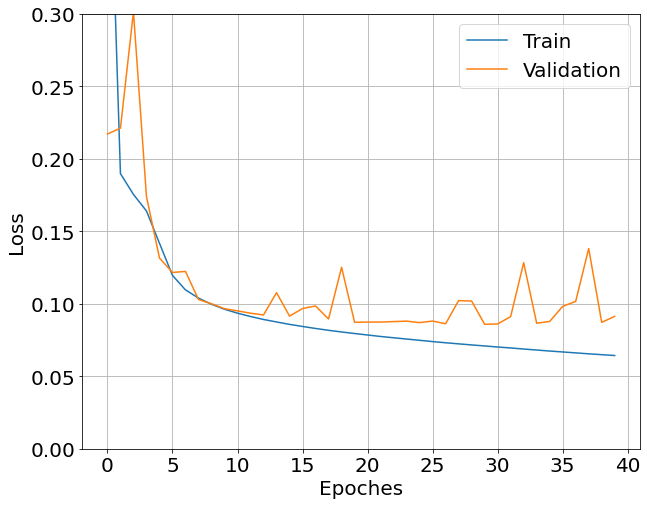

(85723,)
0.06588502294057433


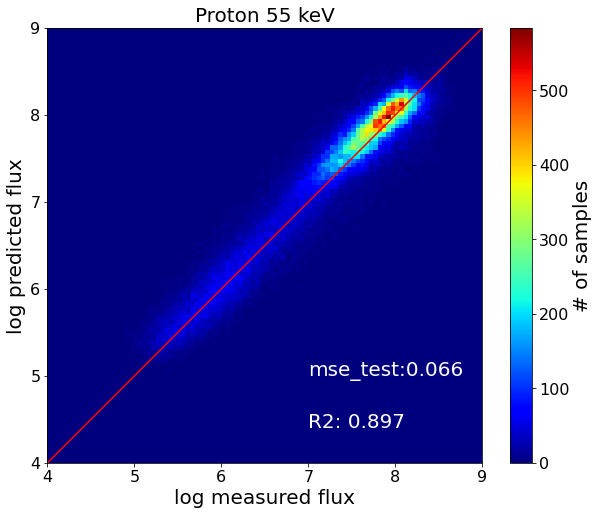

In [22]:
# Calculate the MSE loss function and the correlation between data and predictions
y_test_reshaped=y_test.reshape([-1])
y_test_pred = model.predict(X_test)
y_test_pred_reshaped=y_test_pred.reshape([-1])

lws_rbspice_loss_function_history(history, figname=dir_out+'mse_'+fn1,ylim=[0,0.3]) 
lws_rbspice_correlation(y_test_reshaped, y_test_pred_reshaped, xrange=[4,9],figname=dir_out+'corr_'+fn1,ek=df_flux.columns[iek+1])


### Session 2: Compare the predicted flux and the measurements

In [23]:
## The following sections are to visulize the long-term variation of modeled proton flux
tstr_plot_begin='2017-01-01 00:00:00'
tstr_plot_end='2017-07-01 00:00:00'
class time_series():
    x = []
    y = []
    v = []
    ylabel = 'y'
    xlabel = 'x'
    linecolors = 'k'
    plot_style = 'plt'
    title= 'title'
    vrange=[]
    cmap='jet'

indt1_symh=np.where(df_symh['Datetime'] >= tstr_plot_begin)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] <= tstr_plot_end)
indt2_symh=indt2_symh[0][-1]+1
tarr_dt=df_symh['Datetime'].astype('datetime64')[indt1_symh:indt2_symh].reset_index(drop=True)

indt1_flux=np.where(df_flux['Datetime'][0:N_sample_per_probe] >= tstr_plot_begin)
indt1_flux=indt1_flux[0][0]
indt2_flux=np.where(df_flux['Datetime'][0:N_sample_per_probe] <= tstr_plot_end)
indt2_flux=indt2_flux[0][-1]+1

t_symh = time_series()
t_symh.x = tarr_dt
t_symh.y = df_symh['SymH'][indt1_symh:indt2_symh].reset_index(drop=True)
t_symh.ylabel = 'SymH (nT)'

t_asyh = time_series()
t_asyh.x = tarr_dt
t_asyh.y = df_symh['AsyH'][indt1_symh:indt2_symh].reset_index(drop=True)
t_asyh.ylabel = 'AsyH (nT)'

t_asyd = time_series()
t_asyd.x = tarr_dt
t_asyd.y = df_symh['AsyD'][indt1_symh:indt2_symh].reset_index(drop=True)
t_asyd.ylabel = 'AsyD (nT)'


t_sme = time_series()
t_sme.x = tarr_dt
t_sme.y = df_symh['SME'][indt1_symh:indt2_symh].reset_index(drop=True)
t_sme.ylabel = 'SME (nT)'


t_sml = time_series()
t_sml.x = tarr_dt
t_sml.y = df_symh['SML'][indt1_symh:indt2_symh].reset_index(drop=True)
t_sml.ylabel = 'SML (nT)'


t_vx= time_series()
t_vx.x = tarr_dt
t_vx.y = df_symh['Vx'][indt1_symh:indt2_symh].reset_index(drop=True)
t_vx.ylabel = 'Vx km/s'

t_density = time_series()
t_density.x = tarr_dt
t_density.y = df_symh['Density'][indt1_symh:indt2_symh].reset_index(drop=True)
t_density.ylabel='Density'

t_pflux = time_series()
t_pflux.x = tarr_dt
t_pflux.y = df_coord['L'][indt1_flux:indt2_flux].reset_index(drop=True)
t_pflux.v = df_flux.iloc[:,iek+1][indt1_flux:indt2_flux].reset_index(drop=True)
t_pflux.ylabel = 'L'
t_pflux.plot_style = 'scatter'  # 'colorline'
t_pflux.vrange = [4, 9]

t_flux=[]
for i in range(df_flux.columns.shape[0]):
    t_flux1 = time_series()
    t_flux1.x = tarr_dt
    t_flux1.y = df_coord['L'][indt1_flux:indt2_flux].reset_index(drop=True)
    t_flux1.v = df_flux.iloc[:,(i+1):(i+2)][indt1_flux:indt2_flux].reset_index(drop=True)
    t_flux1.ylabel = 'L'
    t_flux1.plot_style = 'scatter'  # 'colorline'
    t_flux1.vrange = [4, 9]

    t_flux.append(t_flux1)
    del t_flux1

In [24]:
indt1_test=np.where((df_coord['Datetime'][ind_test] >= tstr_plot_begin) & (ind_test < df_coord.shape[0]/2)) 
# probe A: ind_test < df_coord.shape[0]/2; Probe B: # probe A: ind_test >= df_coord.shape[0]/2
indt2_test=np.where((df_coord['Datetime'][ind_test] <= tstr_plot_end  ) & (ind_test < df_coord.shape[0]/2))
indt1_test=indt1_test[0][0]
indt2_test=indt2_test[0][-1]
ind_test_plot=ind_test[indt1_test:indt2_test]
tarr_test=df_coord['Datetime'].astype('datetime64')[ind_test_plot]#.reset_index(drop=True)

t_y_test = time_series()
t_y_test.x = tarr_test
t_y_test.y = df_coord['L'][ind_test_plot]
t_y_test.v = df_flux.iloc[:,iek+1][ind_test_plot]#.reset_index(drop=True)
t_y_test.ylabel = 'L'
t_y_test.plot_style = 'scatter' #'colorline'
t_y_test.vrange=[4,9]
t_y_test.title='Data'
t_y_test.cmap='jet'

t_y_pred = time_series()
t_y_pred.x = tarr_test
t_y_pred.y = df_coord['L'][ind_test_plot]
t_y_pred.v =  y_test_pred_reshaped[0:ind_test_plot.size]
t_y_pred.ylabel = 'L'
t_y_pred.plot_style = 'scatter' #'colorline'
t_y_pred.vrange=[4,9]
t_y_pred.title='Prediction'
t_y_pred.cmap='jet'

t_y_diff = time_series()
t_y_diff.x = tarr_test
t_y_diff.y = df_coord['L'][ind_test_plot]
t_y_diff.v =  y_test_pred_reshaped[0:ind_test_plot.size]-df_flux.iloc[:,iek+1][ind_test_plot].reset_index(drop=True)
t_y_diff.ylabel = 'L'
t_y_diff.plot_style = 'scatter' #'colorline'
t_y_diff.vrange=[-2,2]
t_y_diff.title='Prediction - Data'
t_y_diff.cmap='bwr'

<Figure size 1296x1008 with 0 Axes>

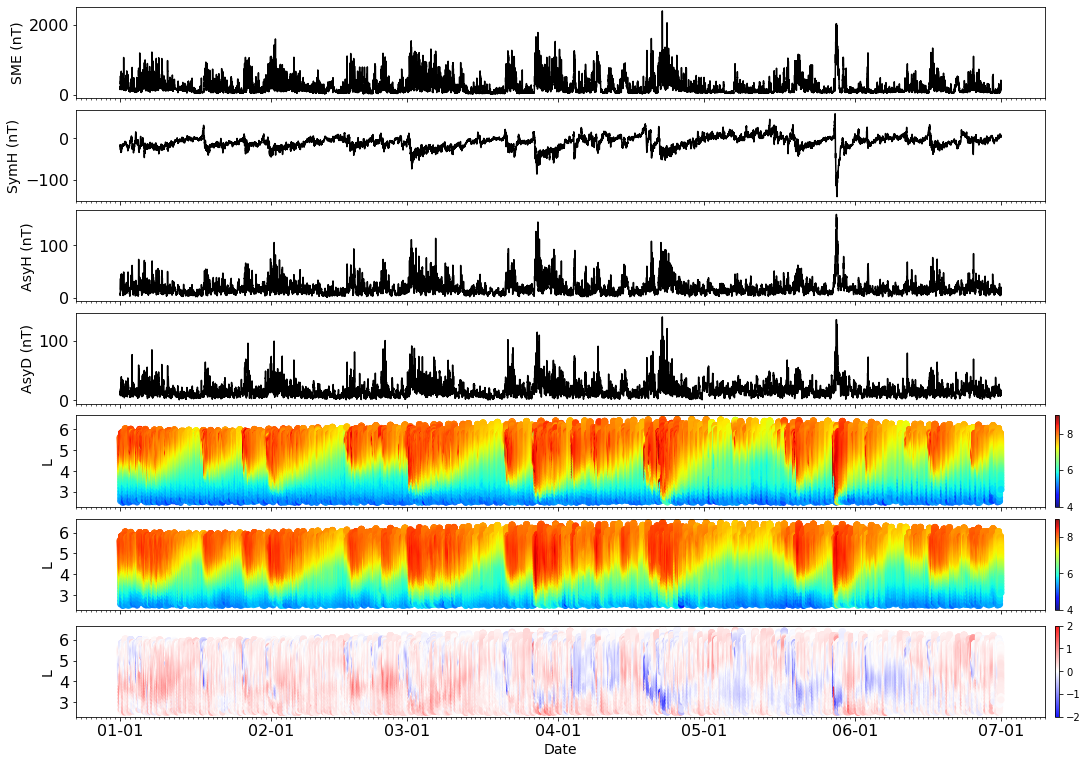

In [25]:
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
fig5=plt.figure(figsize=(18, 14),facecolor='white')   

obj_arr = [t_sme,t_symh,t_asyh,t_asyd,t_y_test,t_y_pred,t_y_diff]
n_subfig= len(obj_arr)

ax_x0=0.2
ax_y0=0.2
ax_xw=0.7
ax_yw=0.7
ax_dy_gap=0.01
ax_dy1=(ax_yw+ax_dy_gap) / n_subfig 
ax_dy0=ax_dy1-ax_dy_gap
fs_label=14

fig5, axs = plt.subplots(n_subfig,1, constrained_layout=True)
fig5.set_size_inches(15, 10.5)

for k in range(n_subfig):
    obj0=obj_arr[k]

    if obj0.plot_style == 'plt':
        s1=axs[k].plot(obj0.x,obj0.y,c=obj0.linecolors)
    elif obj0.plot_style == 'scatter':
        if not obj0.vrange:
            s1=axs[k].scatter(obj0.x,obj0.y,c=obj0.v, cmap=obj0.cmap,alpha=0.9)
        else:
            s1=axs[k].scatter(obj0.x,obj0.y,c=obj0.v, cmap=obj0.cmap,alpha=0.9,vmin=obj0.vrange[0],vmax=obj0.vrange[1])
        axs[k].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        fig5.colorbar(s1, ax=axs[k],fraction=0.02,pad=0.01)
        
    axs[k].set_ylabel(obj0.ylabel,fontsize=fs_label)
    
    if k !=n_subfig-1:
        axs[k].tick_params(axis='x',labelbottom=False) # labels along the bottom edge are off
    else:
        axs[k].tick_params(axis='x',labelbottom=True) # labels along the bottom edge are on
    
    n_ts=obj0.x.shape[0]
    delta_t_days=obj0.x.reset_index(drop=True)[n_ts-1]-obj0.x.reset_index(drop=True)[0]
    if ( delta_t_days < dt.timedelta(days=30) ):
        axs[k].xaxis.set_major_locator(mdates.DayLocator())
        axs[k].xaxis.set_minor_locator(mdates.HourLocator())
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    else:
        axs[k].xaxis.set_major_locator(mdates.MonthLocator())
        axs[k].xaxis.set_minor_locator(mdates.DayLocator())
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    axs[k].tick_params(axis='both', which='major', labelsize=16)
    axs[k].tick_params(axis='both', which='minor', labelsize=12)
    
axs[k].set_xlabel('Date',fontsize=fs_label)
#figname=dir_out+'long_term_'+fn1
#fig5.savefig(figname+"_6.pdf",format='pdf')
#fig5.savefig(figname+"_6.png", format="png", dpi=300)

plt.show()

### Use the RCPANN model to produce global distribution of proton fluxes
This session shows how to use the RCPANN model to produce a global distribution of spin-averaged proton flux at a specific energy, which is stored in "y_pred_matrix". The data y_pred_matrix is the equatorial proton flux in the Xrange of [-6.5, 6.5] and Yrange of [-6.5, 6.5], but only those in the in the radial distance range [2.5, 6.5] are trustful. 

In [29]:
# Definitions for Global distribution
xrange=[-6.5,6.5]
yrange=xrange
delta = 0.1
NX=int((xrange[1]-xrange[0])/delta)
NY=int((yrange[1]-yrange[0])/delta)
extent = (xrange[0], xrange[1], yrange[0], yrange[1])
x = np.arange(xrange[0], xrange[1], delta)
y = np.arange(yrange[0], yrange[1], delta)
XX, YY = np.meshgrid(x, y)


XX_flat=XX.flatten()
YY_flat=YY.flatten()
RR_flat=np.sqrt(XX_flat**2+YY_flat**2)
sint_flat = -YY_flat/RR_flat #Since we defined sint = sin(MLT/12*!pi)
cost_flat = -XX_flat/RR_flat
LAT_flat = XX_flat*0.0
#zero_glb=XX_flat*0.0
LL_flat=(RR_flat-2.5)/(6.57-2.5)*2.0-1.0 # scale from [2.5,6.57] to [0,1]

coord_glb=np.concatenate((LL_flat.reshape([-1,1]),cost_flat.reshape([-1,1]),sint_flat.reshape([-1,1]),LAT_flat.reshape([-1,1])), axis=1)
extent = (xrange[0], xrange[1], yrange[0], yrange[1])
x = np.arange(xrange[0], xrange[1], delta)
y = np.arange(yrange[0], yrange[1], delta)
X, Y = np.meshgrid(x, y)
vmax=9.0
vmin=5.0
norm = mpl.cm.colors.Normalize(vmax=vmax, vmin=vmin)
cmap = mpl.cm.jet

In [30]:
# Compare the period 2015-03-15/12 to 2015-03-20/00
tstr1='2017-03-01 00:02:00'
tstr2='2017-03-04 23:57:00'
indt1_symh=np.where(df_symh['Datetime'] >= tstr1)
indt1_symh=indt1_symh[0][0]
indt2_symh=np.where(df_symh['Datetime'] >= tstr2)
indt2_symh=indt2_symh[0][0]+1
tarr_dt=df_symh['Datetime'].astype('datetime64')[indt1_symh:indt2_symh].reset_index(drop=True)


indt1_coord=np.where(df_coord['Datetime'] >= tstr1)
indt1_coord=indt1_coord[0][0]
indt2_coord=np.where(df_coord['Datetime'] >= tstr2)
indt2_coord=indt2_coord[0][0]+1



529/529 [==============================] - 0s 586us/step


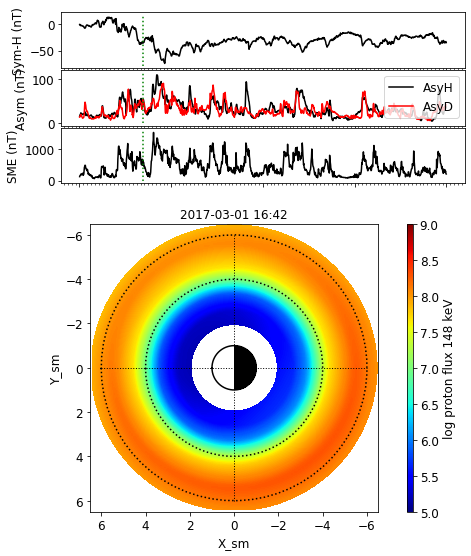

In [31]:

mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

ax_x0=0.2
ax_dx=0.7
ax_dy=0.10
ax_dy_1=0.097
ax_y0=0.55

for k in [200]: #(0,tarr_dt.size,4): [32,200,272]
    tbar=tarr_dt[k]
    indt_glb_1=k+indt1_coord
    fig4=plt.figure(figsize=(8,8),facecolor='white')   
    
    n_fig=4
    #fig = plt.figure(figsize=(18, 14),facecolor='white')   
    fs_label=12
    fs_major=12
    fs_minor=9

    ax1=fig4.add_subplot(n_fig,1,1)
    ax1.set_position([ax_x0,ax_y0+3*ax_dy,ax_dx,ax_dy_1])
    ax1.plot(tarr_dt,df_symh['SymH'][indt1_symh:indt2_symh],'k')
    y_min, y_max = ax1. get_ylim()
    ax1.plot([tbar,tbar],[y_min,y_max],':g')
    ax1.set_ylabel("Sym-H (nT)",fontsize=fs_label)
    ax1.tick_params(axis='x',labelbottom=False) # labels along the bottom edge are off

    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_minor_locator(mdates.HourLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.tick_params(axis='both', which='major', labelsize=fs_major)
    ax1.tick_params(axis='both', which='minor', labelsize=fs_minor)

    ax2=fig4.add_subplot(n_fig,1,2)
    ax2.set_position([ax_x0,ax_y0+2*ax_dy,ax_dx,ax_dy_1])
    ax2.plot(tarr_dt,df_symh['AsyH'][indt1_symh:indt2_symh],'k')
    ax2.plot(tarr_dt,df_symh['AsyD'][indt1_symh:indt2_symh],'r')
    y_min, y_max = ax2. get_ylim()
    ax2.plot([tbar,tbar],[y_min,y_max],':g')
    ax2.set_ylabel("Asym (nT)",fontsize=fs_label)
    ax2.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off

    ax2.xaxis.set_major_locator(mdates.DayLocator())
    ax2.xaxis.set_minor_locator(mdates.HourLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax2.tick_params(axis='both', which='major', labelsize=fs_major)
    ax2.tick_params(axis='both', which='minor', labelsize=fs_minor)
    ax2.legend(('AsyH', 'AsyD'), loc='upper right',fontsize=fs_label)


    ax3=fig4.add_subplot(n_fig,1,3)
    ax3.set_position([ax_x0,ax_y0+1*ax_dy,ax_dx,ax_dy_1])
    ax3.plot(tarr_dt,df_symh['SME'][indt1_symh:indt2_symh],'k')
    y_min, y_max = ax3. get_ylim()
    ax3.plot([tbar,tbar],[y_min,y_max],':g')
    ax3.set_ylabel("SME (nT)",fontsize=fs_label)
    ax3.tick_params(axis='x', labelbottom=False) # labels along the bottom edge are off

    ax3.xaxis.set_major_locator(mdates.DayLocator())
    ax3.xaxis.set_minor_locator(mdates.HourLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.tick_params(axis='both', which='major', labelsize=fs_major)
    ax3.tick_params(axis='both', which='minor', labelsize=fs_minor)

    ax3.xaxis.set_major_locator(mdates.DayLocator())
    ax3.xaxis.set_minor_locator(mdates.HourLocator())
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.tick_params(axis='both', which='major', labelsize=fs_major)
    ax3.tick_params(axis='both', which='minor', labelsize=fs_minor)



    #Subfigure 4
    X_1=X_y_all[indt_glb_1,0:N_ftr].copy()
    X_1_mat=np.matmul(np.ones([NX*NY,1]),X_1.reshape([1,len(X_1)]))
    X_glb=np.concatenate((X_1_mat,coord_glb),axis=1)
    y_glb_pred=model.predict(X_glb)
    y_pred_matrix=y_glb_pred[:,0].reshape([NX,NY])

    ax0=fig4.add_subplot(5,1,5)
    ax0.set_position([0.25,0.08,0.5,0.5])
    im = ax0.contourf(X, Y, y_pred_matrix,  256,cmap=mpl.cm.jet,vmax=vmax,vmin=vmin)

    #Set L>6.5 and L<2 blank
    theta2=np.arange(0,2.01*np.pi,0.02)
    r2=np.arange(6.5,9.5,0.1)
    R,THETA=np.meshgrid(r2,theta2)
    X2=R*np.cos(THETA)
    Y2=R*np.sin(THETA)
    im3=ax0.contourf(X2,Y2,X2*0+1.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)
    r2=np.arange(0.0,2.0,0.1)
    R,THETA=np.meshgrid(r2,theta2)
    X2=R*np.cos(THETA)
    Y2=R*np.sin(THETA)
    im4=ax0.contourf(X2,Y2,X2*0+1.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)


    #Add Earth
    theta=np.arange(0,2.01*np.pi,0.1)
    ax0.plot(np.cos(theta),np.sin(theta),'k')
    r=np.arange(0,1.1,0.1)
    theta1=np.arange(0.5*np.pi,1.5*np.pi,0.02)
    R,THETA=np.meshgrid(r,theta1)
    X1=R*np.cos(THETA)
    Y1=R*np.sin(THETA)
    im2=ax0.contourf(X1,Y1,X1*0+0.0,10,cmap=mpl.cm.cubehelix,vmax=1.0,vmin=0.0)
    #Add 0, 6, 12, 18 sectors and L=4,6
    ax0.plot([-6,6],[0,0],':k',linewidth=1)
    ax0.plot([0,0],[-6,6],':k',linewidth=1)
    ax0.plot(6*np.cos(theta),6*np.sin(theta),':k')
    ax0.plot(4*np.cos(theta),4*np.sin(theta),':k')

    #ax0.set_title('Proton 7.1 keV',fontsize=20)
    ax0.set_xlabel("X_sm",fontsize=fs_label)
    ax0.set_ylabel("Y_sm",fontsize=fs_label)
    ax0.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax0.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax0.tick_params(axis='both', which='major', labelsize=fs_label)
    ax0.tick_params(axis='both', which='minor', labelsize=fs_label)
    plt.axis('equal')
    ax0.set_xlim([-6.5,6.5])
    ax0.set_ylim(-6.5,6.5)
    ax0.invert_xaxis()
    ax0.invert_yaxis()

    # Add colorbar
    cax = plt.axes([0.8, 0.08, 0.01, 0.5])
    cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0,cax=cax)
    cbar.ax.tick_params(labelsize=fs_label)
    cbar.set_label('log proton flux 148 keV', fontsize=fs_label)
    ax0.set_title(tbar.strftime("%Y-%m-%d %H:%M"),fontsize=fs_label)
    dir_out=dir0+'/lws_results/rbspice/p_'+str(df_flux.columns[iek+1])+'_keV/global8/'
    os.makedirs(dir_out, exist_ok = True) 
    plt.savefig(dir_out+"proton_148_kev_global"+str(k)+".png", format="png", dpi=300)
    #plt.savefig(dir_out+"proton_55_kev_global"+str(k)+".pdf",format='pdf')
    #plt.show()
